# Battery Model  
## Prompt  
Create a ‘dummy’ NEM12 file online (and ideally one that reflects a relevant customer segment). Build a simple modelling tool to analyse the cost and benefit of installing a battery on-site. Explain your method and approach, showing your working.  
We are more interested in how you think through the method than the complexity of the modelling or accuracy of your answer.

## Libraries to be used

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

## Creating the NEM12 csv data  
I generated a sample NEM12 dataset for an industrial customer in VIC using ChatGPT.  
The interval length was defined as 30 minutes, and the data represents a total duration of one calendar year.  
I saved the raw NEM12 csv file on Github, and it can be accessed at the URL below.

In [2]:
NEM_url = 'https://raw.githubusercontent.com/jero-99/Interview_FlowPower/refs/heads/main/Data/Sample_NEM12_Raw.csv'

## Reading the NEM12 csv data  
Before reading the csv file, I needed a way to account for the inconsistent number of columns within each row.  
Because there are a total of 52 columns in each 300 data record row, I define a list of length 52. 

In [3]:
NEM_headers = []

for x in range(0,52):
    NEM_headers.append(x)

Here the script reads the csv file into a dataframe.

In [4]:
NEM_raw = pd.read_csv(NEM_url,names=NEM_headers,header=None,engine='python')
##NEM_raw.head(NEM_raw.shape[0])

## Cleaning up the NEM12 data  
The raw dataframe is not very friendly to work on.  
Ideally, I would like to perform my analysis on a "clean" dataframe that contains just two columns - date/time and consumption.  
Here I process the raw dataframe into a clean one.

In [5]:
##This is the metered data interval, in this case 30 minutes
Time_interval = 0
##Time_start is the starting date and time of the metered data, in this case Jan 1st 2024
Time_start = 0
##To be used as a running value to keep track of the time stamp for the consumption data
Time_stamp = 0

NEM_clean = []

##This for loop reads out all entries contained within the 300 data record rows 
##and places them into one central list along with their corresponding time stamps
for index, row in NEM_raw.iterrows():
    if row[0] == 200:
        Time_interval = int(row[4])
        ##print(time_Interval)
        Time_start = datetime.strptime(str(int(row[5])),"%Y%m%d%H%M%S")
        Time_stamp = Time_start
        ##print(time_Start)
    elif row[0] == 300:
        for i in row[2:-2]:
            NEM_clean.append([Time_stamp,float(i)])
            ##print([time_Stamp,float(i)])
            Time_stamp += timedelta(minutes=Time_interval)

NEM_clean = pd.DataFrame(NEM_clean, columns=["Timestamp","Consumption"])
##NEM_clean.head(NEM_clean.shape[0])

## Sourcing the electric price data  
I found electric spot price data on the following website:  
https://aemo.com.au/energy-systems/electricity/national-electricity-market-nem/data-nem/data-dashboard-nem  
The data is for the state of VIC.  
The interval length was 5 minutes, and the data represents a total duration of one day from Feb 25th to 26th.  
I saved the raw electric price csv file on Github, and tt can be accessed at the URL below.

In [6]:
ElecPrice_url = 'https://raw.githubusercontent.com/jero-99/Interview_FlowPower/refs/heads/main/Data/Electricity_Price_Raw.csv'

## Reading the electric price data  
Reading the electric data is straight forward

In [7]:
ElecPrice_raw = pd.read_csv(ElecPrice_url)
##ElecPrice_raw.head(ElecPrice_raw.shape[0])

## Cleaning up the electric price data  
Again, the raw dataframe is not very friendly to work on.  
I would like a clean dataframe that shows half-hourly time stamps using actual data with spot price in $/kWh.  
Here I process the raw dataframe into a clean one.

In [8]:
##Conversion between MWh and kWh
MWh_kWh_conv = 1000

ElecPrice_clean = []

##Filtering for actual data and leaving out forecasted data
ElecPrice_clean = ElecPrice_raw[ElecPrice_raw["Type"] == "ACTUAL"].copy()

##Deleting unnecessary columns
ElecPrice_clean = ElecPrice_clean.drop(columns = ["Scheduled Demand (MW)","Scheduled Generation (MW)","Semi Scheduled Generation (MW)","Net Import (MW)","Type"])

##Electric price data came in 5 minute intervals
##Here I isolate the electric price data into 30 minute intervals
ElecPrice_clean["Settlement Date"] = pd.to_datetime(ElecPrice_clean["Settlement Date"],dayfirst=True)
ElecPrice_clean = ElecPrice_clean[ElecPrice_clean["Settlement Date"].dt.minute.isin([0,30])]
ElecPrice_clean["Settlement Date"] = ElecPrice_clean["Settlement Date"].dt.strftime("%H:%M:%S")
ElecPrice_clean = ElecPrice_clean.rename(columns = {"Settlement Date":"Settlement Time"})

##And also convert the spot price from $/MWh to $/kWh to align with the metered data
ElecPrice_clean["Spot Price ($/MWh)"] = ElecPrice_clean["Spot Price ($/MWh)"].div(MWh_kWh_conv)
ElecPrice_clean = ElecPrice_clean.rename(columns = {"Spot Price ($/MWh)":"Spot Price ($/kWh)"})

##ElecPrice_clean.head(ElecPrice_clean.shape[0])

## Merging the NEM12 and electric price dataframes  
With clean dataframes, they now need to be merged in order to begin modelling.  
For each timestamp in the clean NEM dataframe, I need to add a new column showing its corresponding spot price.  
Because I only have one day of spot price data, for the sake of this example I have to assume that the daily spot price is the same for every day of the year.

In [9]:
##Define a dictionary relating time and price, see line 8
Price_dict = []
##Price_temp allows me to temporarily build a list of prices before merging it with the clean NEM12 dataframe
Price_temp = []
##To be used to house the merged dataframes
Model_data = []

Price_dict = {row["Settlement Time"]: row["Spot Price ($/kWh)"] for index, row in ElecPrice_clean.iterrows()}
##print(Price_dict)

Model_data = NEM_clean.copy()
##Model_data.head(Model_data.shape[0])

##Building out a temporary list of prices by looping through all rows in the NEM12 dataframe to ensure all time stamps have a corresponding spot price
for index, row in Model_data.iterrows():
    Price_temp.append(Price_dict.get(row["Timestamp"].strftime("%H:%M:%S"),None))

##Merging the dataframes
Model_data["Price"] = Price_temp
##Model_data.head(Model_data.shape[0])

## Baseline model  
Calculate the baseline (pre-battery) annual electricity cost.

In [10]:
##Initialising some variables
Baseline_cost = []
Baseline_data = Model_data.copy()
Baseline_annual_cost = 0

##Cost = Consumption (kWh) x Price ($/kWh)
Baseline_cost = Baseline_data.Consumption * Baseline_data.Price
##Sum across a full year to get the annual cost
Baseline_annual_cost = Baseline_cost.sum()
print(f"The baseline annual cost is: ${'{:,}'.format(round(Baseline_annual_cost,2))}")

The baseline annual cost is: $200,242.76


Here I show a sample plot over two days, Jan 1st to Jan 2nd.

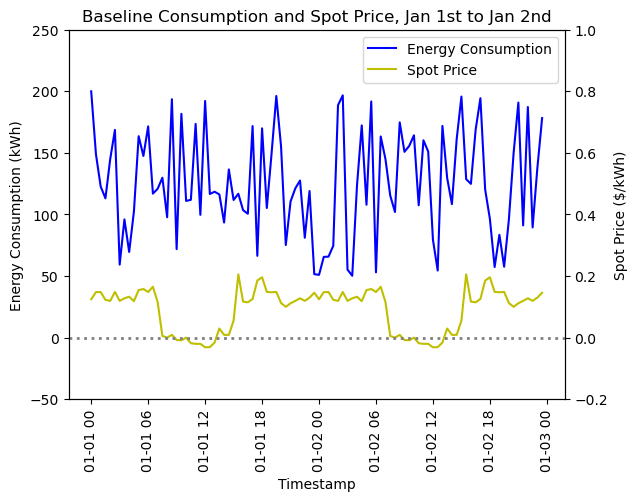

In [11]:
fig, ax1 = plt.subplots()
ln1 = ax1.plot(Model_data["Timestamp"].head(96), Model_data["Consumption"].head(96), label = "Energy Consumption", color = "b")
ax1.set_xlabel("Timestamp")
ax1.tick_params(axis = "x", labelrotation = 90)
ax1.set_ylabel("Energy Consumption (kWh)")
ax1.set_ylim([-50,250])

ax2 = plt.twinx()
ln2 = ax2.plot(Model_data["Timestamp"].head(96), Model_data["Price"].head(96), label = "Spot Price", color = "y")
ax2.set_ylabel("Spot Price ($/kWh)")
ax2.set_ylim([-0.2,1])

lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc = 0)
plt.axhline(y = 0, linewidth = 2, color = "gray", ls=':')
ax1.set_title("Baseline Consumption and Spot Price, Jan 1st to Jan 2nd")
plt.show()

## Proposed model 
As a simple example, I will model a battery used to completely offset usage from 4pm to 8pm.  
The battery must be able to offset usage between 4pm and 8pm on the most energy intensive day of the year.  
The battery should discharge and recharge between 20% and 100% each day.  
First, I need to calculate the minimum capacity of the battery by finding the usage on the most energy intensive day of the year between 4pm to 8pm.

In [12]:
##Copying over the merged dataframe to not make any unwanted edits to the original data
Battery_temp_data = Model_data.copy()
##Temporary variables used to find the max usage between 4pm and 8pm
Temp_max = 0
Temp_sum = 0
##Min and max battery specs
Min_discharge = 0.2
Max_recharge = 1
##Initialising to be defined in line 25
Battery_min_capacity = 0
##Here I arbitrarily define a standard increment in battery size
##Intended to be used to round the battery capacity up to the next highest increment
##In real life this information would like be provided by the manufacturer
##For example if a manufacturer only makes battery packs in 0.5 MWh increments
Battery_capacity_increment = 500

##In this for loop, I sum the electric consumption data of rows between 4pm (hour 16) and 8pm (hour 20)
for i, row in Battery_temp_data.iterrows():
    if row["Timestamp"] == Time_start:
        pass
    elif 0 <= row["Timestamp"].hour < 16:
        pass
    elif 16 <= row["Timestamp"].hour < 20:
        Temp_sum += Battery_temp_data.at[i,"Consumption"]
##At the end of each 4pm to 8pm segment, this if statement checks if the recently summed consumption is greater than a previously determined max
    elif row["Timestamp"].hour >= 20:
        if Temp_sum > Temp_max:
            Temp_max = Temp_sum
        Temp_sum = 0

##Calculating the battery capacity, accounting for the charge specs and the arbitrary increment
Battery_min_capacity = round((Temp_max / (Max_recharge - Min_discharge)) / Battery_capacity_increment) * Battery_capacity_increment

##print(Temp_max)
print(f"The minimum battery capacity is: {'{:,}'.format(Battery_min_capacity)} kWh")

The minimum battery capacity is: 2,000 kWh


Now that the minimum capacity has been calculated, I can use that to model the performance of the battery after it is installed

In [13]:
##Copying over the merged dataframe to not make any unwanted edits to the original data
Proposed_data = Model_data.copy()
##Proposed_capacity keeps track of the "real-time" capacity of the battery
Proposed_capacity = []
##Proposed_charge keeps track of periods where the battery is being charged
Proposed_charge = []
##Proposed_discharge keeps track of period where the battery is being discharged
Proposed_discharge = []
##Similar to what I have described above in the merging dataframes section,
##These last three variables allow me to temporarily build lists before merging them with the main dataframe

##Here I arbitrarily define a charging rate and efficiency
##Similar to the increment above, this can be changed based on manufacturer specs
Battery_charge_rate = 200
Battery_efficiency = 0.95

##In this for loop, I determine how much a battery needs to discharge in order to eliminate all grid demand between 4pm (hour 16) and 8pm (hour 20)
##Between 8pm and 4pm, the if statements check to see if the battery needs to be charged
##If so, the battery is charged up to its original capacity or no more than the arbitrary charging rate defined above
##The battery efficiency is also accounted for
for i, row in Proposed_data.iterrows():
    if row["Timestamp"] == Time_start:
        Proposed_capacity.append(Battery_min_capacity)
        Proposed_charge.append(0)
        Proposed_discharge.append(0)
    elif 0 <= row["Timestamp"].hour < 16:
        if Proposed_capacity[i-1] < Battery_min_capacity:
            Proposed_capacity.append(min(Battery_min_capacity, Proposed_capacity[i-1] + Battery_charge_rate * Battery_efficiency))
            Proposed_charge.append((Proposed_capacity[i]-Proposed_capacity[i-1]) / Battery_efficiency)
            Proposed_discharge.append(0)
        elif Proposed_capacity[i-1] >= Battery_min_capacity:
            Proposed_capacity.append(Battery_min_capacity)
            Proposed_charge.append(0)
            Proposed_discharge.append(0)
    elif 16 <= row["Timestamp"].hour < 20:
        Proposed_capacity.append(Proposed_capacity[i-1] - Proposed_data.at[i,"Consumption"])
        Proposed_charge.append(0)
        Proposed_discharge.append(Proposed_data.at[i,"Consumption"])
        Proposed_data.at[i,"Consumption"] = 0
    elif row["Timestamp"].hour >= 20:
        if Proposed_capacity[i-1] < Battery_min_capacity:
            Proposed_capacity.append(min(Battery_min_capacity, Proposed_capacity[i-1] + Battery_charge_rate * Battery_efficiency))
            Proposed_charge.append((Proposed_capacity[i]-Proposed_capacity[i-1]) / Battery_efficiency)
            Proposed_discharge.append(0)
        elif Proposed_capacity[i-1] >= Battery_min_capacity:
            Proposed_capacity.append(Battery_min_capacity)
            Proposed_charge.append(0)
            Proposed_discharge.append(0)

##Merging the dataframes
Proposed_data["Capacity"] = Proposed_capacity
Proposed_data["Charge"] = Proposed_charge
Proposed_data["Discharge"] = Proposed_discharge
Proposed_data["TotalConsumption"] = Proposed_data["Consumption"] + Proposed_data["Charge"]
##Proposed_data.head(Proposed_data.shape[0])

Calculate the proposed (post-battery) annual electricity cost.

In [14]:
##Same process as the baseline case
Proposed_cost = []
Proposed_annual_cost = 0

Proposed_cost = Proposed_data.TotalConsumption * Proposed_data.Price
Proposed_annual_cost = Proposed_cost.sum()
print(f"The proposed annual cost is: ${'{:,}'.format(round(Proposed_annual_cost,2))}")

The proposed annual cost is: $190,121.15


Again, here is a sample plot over two days, Jan 1st to Jan 2nd.  
Note the energy consumption goes to zero between 4pm and 8pm, as expected.

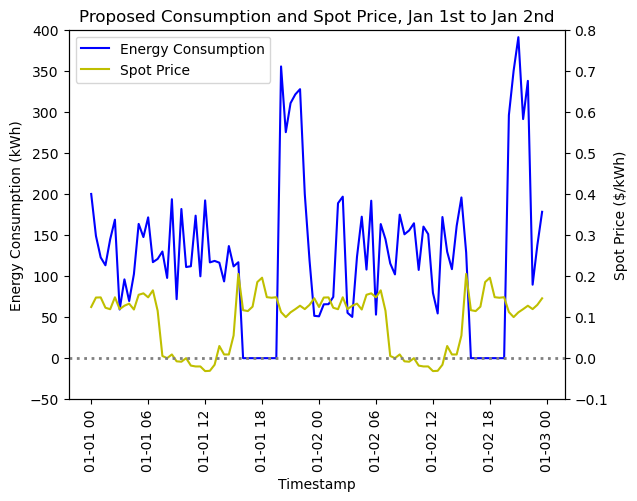

In [15]:
fig, ax1 = plt.subplots()
ln1 = ax1.plot(Proposed_data["Timestamp"].head(96), Proposed_data["TotalConsumption"].head(96), label = "Energy Consumption", color = "b")
ax1.set_xlabel("Timestamp")
ax1.tick_params(axis = "x", labelrotation = 90)
ax1.set_ylabel("Energy Consumption (kWh)")
ax1.set_ylim([-50,400])

ax2 = plt.twinx()
ln2 = ax2.plot(Proposed_data["Timestamp"].head(96), Proposed_data["Price"].head(96), label = "Spot Price", color = "y")
ax2.set_ylabel("Spot Price ($/kWh)")
ax2.set_ylim([-0.1,0.8])

lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc = 0)
plt.axhline(y = 0, linewidth = 2, color = "gray", ls=':')
ax1.set_title("Proposed Consumption and Spot Price, Jan 1st to Jan 2nd")
plt.show()

Another potentially useful plot of the charging/discharging behavior of the battery and the storage capacity.

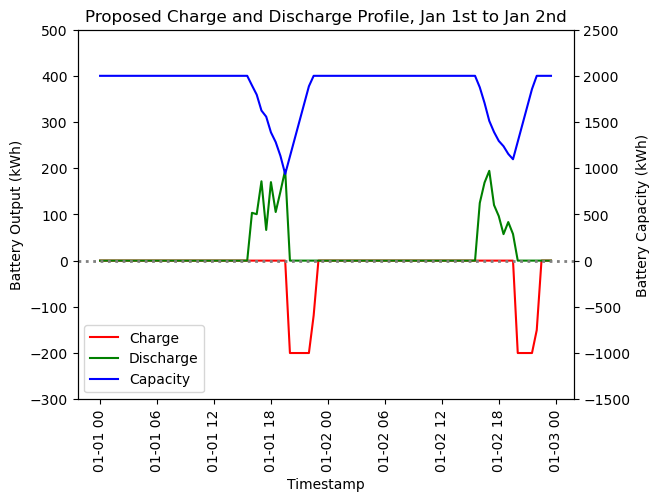

In [16]:
fig, ax1 = plt.subplots()
ln1 = ax1.plot(Proposed_data["Timestamp"].head(96), -Proposed_data["Charge"].head(96), label = "Charge", color = "r")
ax1.set_xlabel("Timestamp")
ax1.tick_params(axis = "x", labelrotation = 90)
ln2 = ax1.plot(Proposed_data["Timestamp"].head(96), Proposed_data["Discharge"].head(96), label = "Discharge", color = "g")
ax1.set_ylabel("Battery Output (kWh)")
ax1.set_ylim([-300,500])

ax2 = plt.twinx()
ln3 = ax2.plot(Proposed_data["Timestamp"].head(96), Proposed_data["Capacity"].head(96), label = "Capacity", color = "b")
ax2.set_ylabel("Battery Capacity (kWh)")
ax2.set_ylim([-1500,2500])

lns = ln1 + ln2 + ln3
lab = [l.get_label() for l in lns]
ax1.legend(lns, lab, loc = 3)
plt.axhline(y = 0, linewidth = 2, color = "gray", ls=':')
ax1.set_title("Proposed Charge and Discharge Profile, Jan 1st to Jan 2nd")
plt.show()

## Key Performance Figures

In [17]:
#Total MWh charged
MWh_charged = round(Proposed_data["Charge"].sum()/MWh_kWh_conv,1)
#Average charge price is how much charging the battery cost per MWh
Charge_cost = Proposed_data["Price"] * Proposed_data["Charge"]
Charge_price_average = Charge_cost.sum() / MWh_charged
#Charge capacity factor
Charge_CF = round(Proposed_data["Charge"].astype(bool).sum(axis=0)/Proposed_data.shape[0],2) * 100

#Total MWh discharged
MWh_discharged = round(Proposed_data["Discharge"].sum()/MWh_kWh_conv,1)
#Average price avoided during discharge is how much electricity would've cost without the battery
Discharge_cost = Proposed_data["Price"] * Proposed_data["Discharge"]
Discharge_price_average = Discharge_cost.sum() / MWh_discharged
#Discharge capacity factor
Discharge_CF = round(Proposed_data["Discharge"].astype(bool).sum(axis=0)/Proposed_data.shape[0],2) * 100

print(f"Total Energy Charged: {MWh_charged} MWh")
print(f"Average Charge Price: ${'{:,}'.format(round(Charge_price_average,2))}/MWh")
print(f"Charge Capacity Factor: {Charge_CF}%")
print(f"Total Energy Discharged: {MWh_discharged} MWh")
print(f"Average Price Avoided During Discharge: ${'{:,}'.format(round(Discharge_price_average,2))}/MWh")
print(f"Discharge Capacity Factor: {Discharge_CF}%")

Total Energy Charged: 388.4 MWh
Average Charge Price: $114.36/MWh
Charge Capacity Factor: 12.0%
Total Energy Discharged: 368.9 MWh
Average Price Avoided During Discharge: $147.85/MWh
Discharge Capacity Factor: 17.0%


## Key Financial Figures

In [18]:
#Battery cost
Battery_cost = 100 #$/kWh
Battery_capital = Battery_cost * Battery_min_capacity
#Cost savings
Cost_savings = Baseline_annual_cost - Proposed_annual_cost
#Payback period
Payback_period = Battery_capital / Cost_savings

print(f"Battery Installation Cost: ${'{:,}'.format(round(Battery_capital,2))}")
print(f"Baseline Annual Electricity Cost: ${'{:,}'.format(round(Baseline_annual_cost,2))}/year")
print(f"Proposed Annual Electricity Cost: ${'{:,}'.format(round(Proposed_annual_cost,2))}/year")
print(f"Annual Cost Savings: ${'{:,}'.format(round(Cost_savings,2))}/year")
print(f"Payback Period: {round(Payback_period,1)} years")

Battery Installation Cost: $200,000
Baseline Annual Electricity Cost: $200,242.76/year
Proposed Annual Electricity Cost: $190,121.15/year
Annual Cost Savings: $10,121.61/year
Payback Period: 19.8 years
